## Lunar Lander (Reinforcement Learning)

### Imports

In [109]:
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

import io
import sys
import csv

import warnings
warnings.filterwarnings("ignore")

### Define Environment and Actions

In [110]:
ENV_NAME = 'LunarLander-v2'

In [111]:
# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Create a Simple Model

In [112]:
# Next, we build a very simple model.
model = Sequential()

model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

model.add(Dense(40))
model.add(Activation('relu'))

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(nb_actions))
model.add(Activation('linear'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 40)                360       
_________________________________________________________________
activation_8 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               20992     
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 2052      
_________________________________________________________________
activation_10 (Activation)   (None, 4)                 0         
Total para

### Compile the Model

In [113]:
# Finally, we configure and compile our agent using built-in Keras optimizer and metrics
memory = SequentialMemory(limit=300000, window_length=1)
policy = EpsGreedyQPolicy()

dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=50000,
               target_model_update=1e-2, policy=policy)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])

### Train the Model

In [114]:
# Redirect stdout to capture train results
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()

# Okay, now it's time to learn something!
dqn.fit(env, nb_steps=2000000, visualize=False, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

results
Training for 2000000 steps ...
      65/2000000: episode: 1, duration: 0.152s, episode steps: 65, steps per second: 428, episode reward: -122.825, mean reward: -1.890 [-100.000, 16.176], mean action: 0.492 [0.000, 3.000], mean observation: -0.026 [-1.537, 1.000], loss: --, mean_absolute_error: --, mean_q: --
     119/2000000: episode: 2, duration: 0.026s, episode steps: 54, steps per second: 2060, episode reward: -174.098, mean reward: -3.224 [-100.000, 7.349], mean action: 0.333 [0.000, 2.000], mean observation: -0.040 [-4.727, 1.028], loss: --, mean_absolute_error: --, mean_q: --
     186/2000000: episode: 3, duration: 0.033s, episode steps: 67, steps per second: 2008, episode reward: -152.083, mean reward: -2.270 [-100.000, 18.618], mean action: 0.403 [0.000, 3.000], mean observation: 0.043 [-1.669, 3.206], loss: --, mean_absolute_error: --, mean_q: --
     265/2000000: episode: 4, duration: 0.054s, episode steps: 79, steps per second: 1457, episode reward: -504.120, mean re

### Save Rewards for Training 

In [116]:
# Reset stdout
sys.stdout = old_stdout
results_text_fit = mystdout.getvalue()

# Print results text
print("results")
print(results_text_fit)

# Extact a rewards list from the train results
results_fit = list()
for idx, line in enumerate(results_text_fit.split('\n')):
    if idx > 0 and len(line) > 1:
        results_fit.append(line)

episode = list()
episode_rewards = list()
mean_absolute_errors = list()
mean_q = list()

for idx, line in enumerate(results_fit[:-1]):
    ep = int(line.split(':')[2].split(',')[0].strip())
    ep_rewards = float(line.split(":")[6].split(",")[0].strip())
    episode.append(ep)
    episode_rewards.append(ep_rewards)

# Create dataframe to store the episodes and rewards 
df = pd.DataFrame({'Episode': episode, 'Rewards': episode_rewards}).set_index('Episode')

# Write total rewards to a csv file
df.to_csv("lunarlander_rl_rewards_fit.csv")

results
Training for 2000000 steps ...
      65/2000000: episode: 1, duration: 0.152s, episode steps: 65, steps per second: 428, episode reward: -122.825, mean reward: -1.890 [-100.000, 16.176], mean action: 0.492 [0.000, 3.000], mean observation: -0.026 [-1.537, 1.000], loss: --, mean_absolute_error: --, mean_q: --
     119/2000000: episode: 2, duration: 0.026s, episode steps: 54, steps per second: 2060, episode reward: -174.098, mean reward: -3.224 [-100.000, 7.349], mean action: 0.333 [0.000, 2.000], mean observation: -0.040 [-4.727, 1.028], loss: --, mean_absolute_error: --, mean_q: --
     186/2000000: episode: 3, duration: 0.033s, episode steps: 67, steps per second: 2008, episode reward: -152.083, mean reward: -2.270 [-100.000, 18.618], mean action: 0.403 [0.000, 3.000], mean observation: 0.043 [-1.669, 3.206], loss: --, mean_absolute_error: --, mean_q: --
     265/2000000: episode: 4, duration: 0.054s, episode steps: 79, steps per second: 1457, episode reward: -504.120, mean re

### Plot the Training Rewards for Evaluation

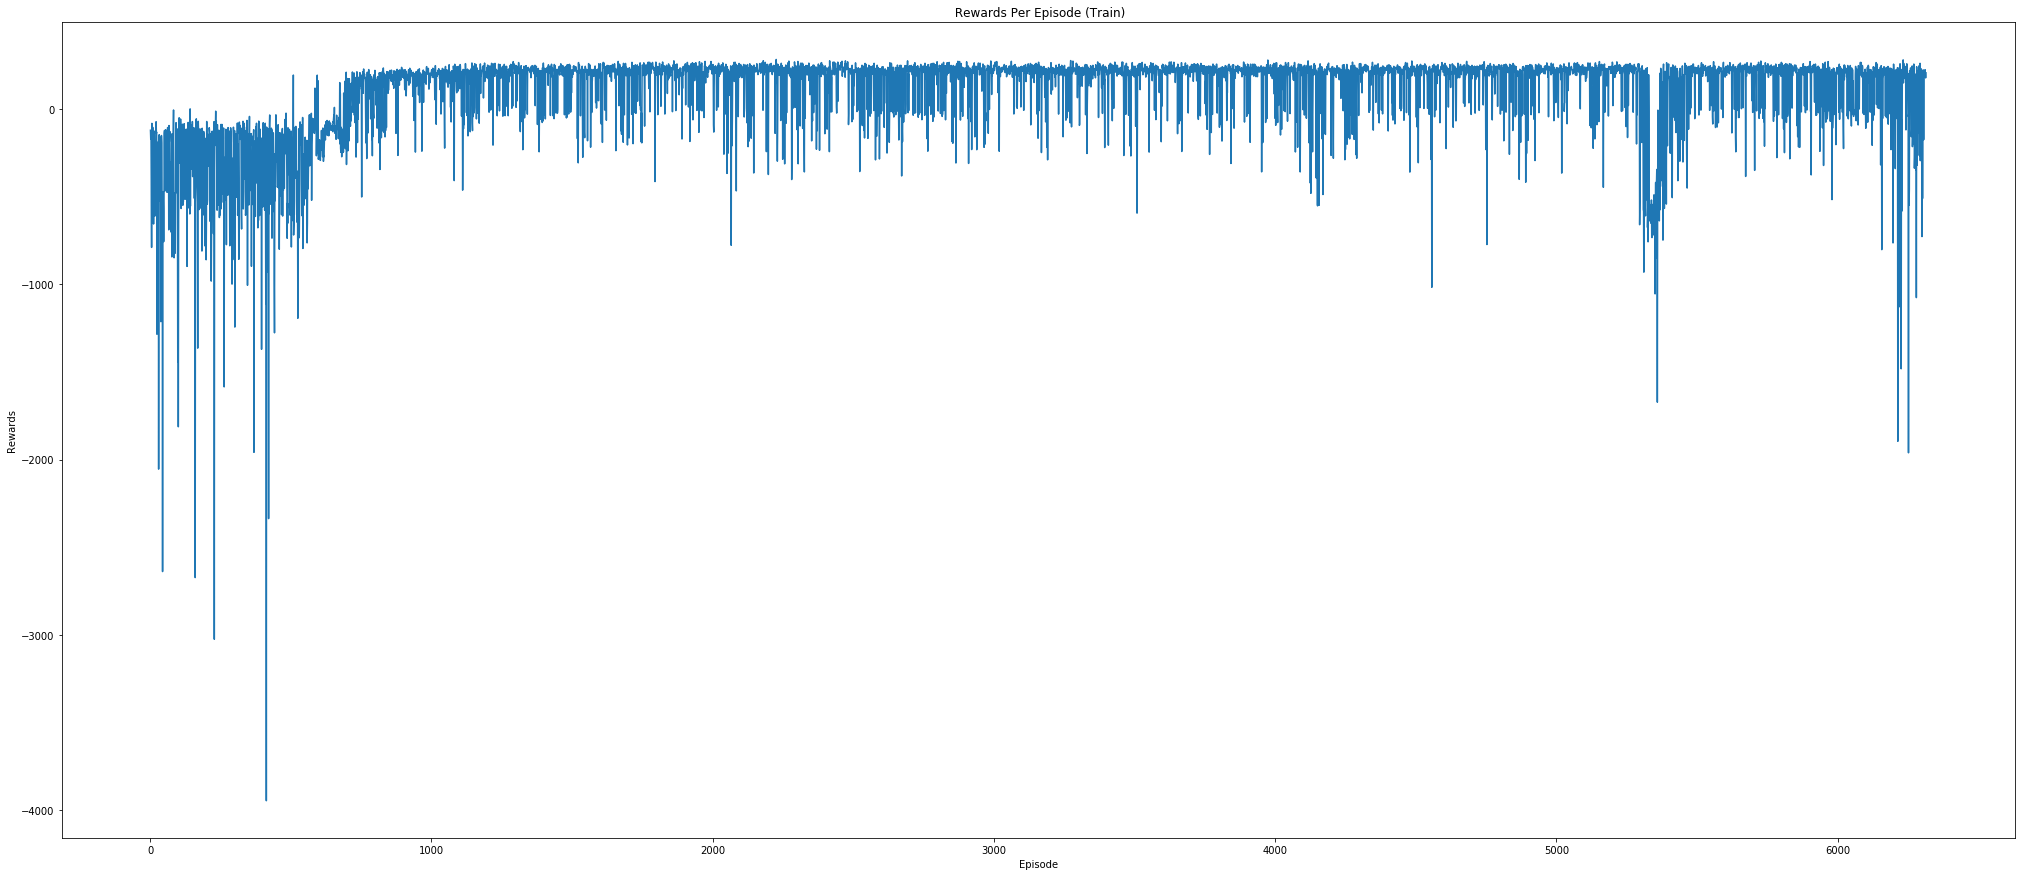

In [117]:
# Plot the train rewards for each episode
plot_fit = df[['Rewards']]

plt.figure(figsize=(35,15))
plt.plot(plot_fit)

plt.title(" Rewards Per Episode (Train)")
plt.xlabel("Episode")
plt.ylabel("Rewards")

plt.show()

### Test Model for 200 Episodes 

In [118]:
# Redirect stdout to capture test results
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()

# Finally, evaluate our algorithm for 200 episodes.
dqn.test(env, nb_episodes=200, visualize=False)

results
Testing for 200 episodes ...
Episode 1: reward: 130.502, steps: 1000
Episode 2: reward: 182.008, steps: 445
Episode 3: reward: 232.701, steps: 825
Episode 4: reward: 202.499, steps: 499
Episode 5: reward: 201.704, steps: 606
Episode 6: reward: 207.397, steps: 299
Episode 7: reward: 111.285, steps: 1000
Episode 8: reward: 144.499, steps: 1000
Episode 9: reward: 222.462, steps: 348
Episode 10: reward: 97.877, steps: 1000
Episode 11: reward: 61.856, steps: 1000
Episode 12: reward: 231.879, steps: 627
Episode 13: reward: 105.499, steps: 1000
Episode 14: reward: 55.757, steps: 1000
Episode 15: reward: 63.951, steps: 1000
Episode 16: reward: 201.461, steps: 931
Episode 17: reward: 216.492, steps: 506
Episode 18: reward: 203.897, steps: 409
Episode 19: reward: 203.135, steps: 371
Episode 20: reward: 106.337, steps: 1000
Episode 21: reward: 194.675, steps: 301
Episode 22: reward: 124.230, steps: 1000
Episode 23: reward: 188.861, steps: 346
Episode 24: reward: 89.753, steps: 1000
Episod

### Save Rewards for Test

In [119]:
# Reset stdout
sys.stdout = old_stdout

results_text = mystdout.getvalue()

# Print results text
print("results")
print(results_text)

# Extact a rewards list from the test results
episode = list()
total_rewards = list()
for idx, line in enumerate(results_text.split('\n')):
    if idx > 0 and len(line) > 1:
        ep = int(line.split(" ")[1].split(":")[0].strip())
        reward = float(line.split(':')[2].split(',')[0].strip())
        total_rewards.append(reward)
        episode.append(ep)

# Print rewards and average	
print("total rewards", total_rewards)
print("average total reward", np.mean(total_rewards))

# Create dataframe to store the episodes and rewards 
df = pd.DataFrame({'Episode': episode, 'Rewards': total_rewards}).set_index('Episode')

# Write total rewards to a csv file
df.to_csv("lunarlander_rl_rewards_test.csv")

### Plot the Test Rewards for Evaluation

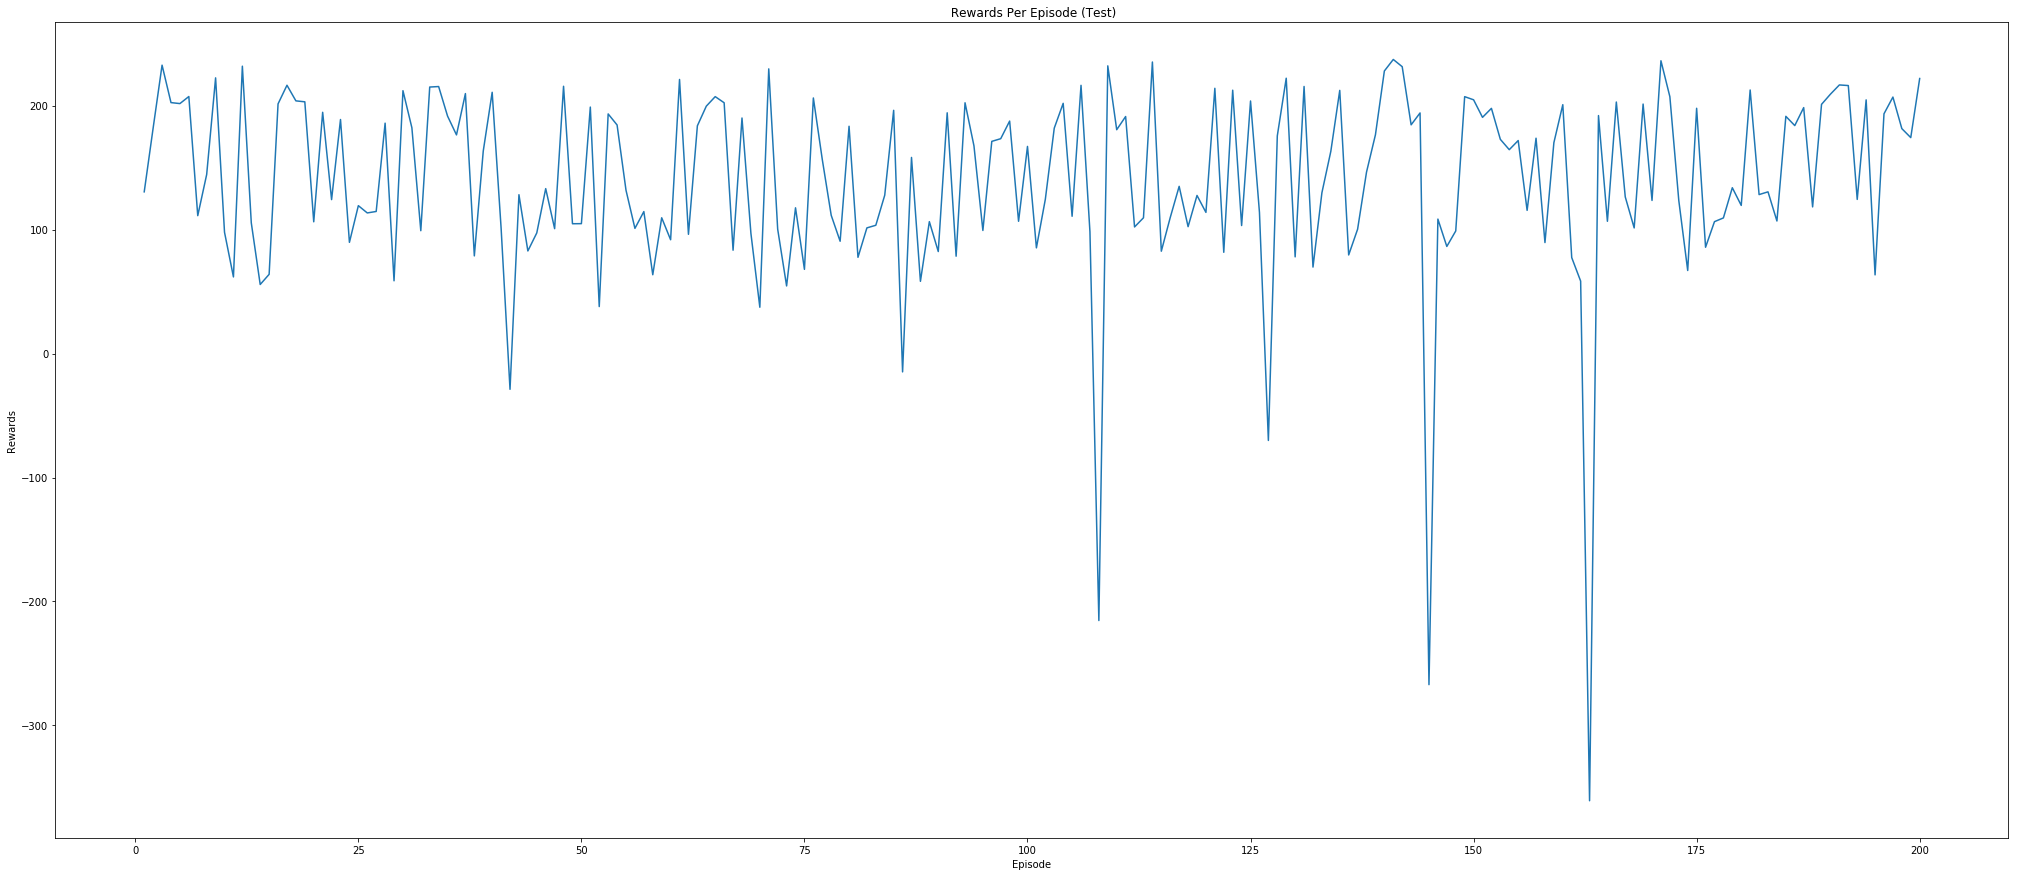

In [120]:
# Plot the test rewards for each episode
plot_test = df[['Rewards']]

plt.figure(figsize=(35,15))
plt.plot(plot_test)

plt.title(" Rewards Per Episode (Test)")
plt.xlabel("Episode")
plt.ylabel("Rewards")

plt.show()